# Figures for paper

In [1]:
import os
import torch
import json

import matplotlib.pyplot as plt


In [2]:

plt.style.use('./arena.mplstyle')
# Colors from the palette
BLUE = '#1d3557'
CLAY = '#b8977e'

In [3]:
plot_output_dir = "/root/git/plots/paper"
os.makedirs(plot_output_dir, exist_ok=True)

## Figure 1

trajectory

In [ ]:
model_short = "llama-3.3-70b"
filename = "isolation"
exp_id = "layers_56:72-p0.25"
acts_output_dir = f"/workspace/{model_short}/conversations"
layer = 56

In [16]:

conversation_file = f"/root/git/persona-subspace/dynamics/results/{model_short}/interactive/{filename}.json"
steered_conversation_file = f"/root/git/persona-subspace/dynamics/results/{model_short}/steered/{exp_id}/{filename}.json"

acts_file = f"{acts_output_dir}/{filename}_layer{layer}.pt"
steered_acts_file = f"{acts_output_dir}/{exp_id}_{filename}_layer{layer}_capped.pt"

activations_obj = torch.load(acts_file, weights_only=False, map_location="cpu")
mean_acts_per_turn = activations_obj['activations']
print(mean_acts_per_turn.shape)

steered_activations_obj = torch.load(steered_acts_file, weights_only=False, map_location="cpu")
steered_mean_acts_per_turn = steered_activations_obj['activations']

print(len(mean_acts_per_turn))

conversation_obj = json.load(open(conversation_file))
conversation = conversation_obj['conversation']

steered_conversation_obj = json.load(open(steered_conversation_file))
steered_conversation = steered_conversation_obj['conversation']

torch.Size([32, 5120])
32


In [17]:
import numpy as np
import torch.nn.functional as F

# Load, normalize, and flip contrast vector
# Flipping so positive = more assistant-like, negative = more role-playing
contrast_vector = torch.load(f"/workspace/{model_short}/roles_240/contrast_vectors.pt", weights_only=False)[layer]
contrast_vector = F.normalize(contrast_vector, dim=0)
contrast_vector = contrast_vector.float() * -1  # flip direction

In [18]:
import pandas as pd

# Load role/trait projections and compute stats for shading
role_file = f"/workspace/{model_short}/capped/projections/contrast/roles_projections.jsonl"
trait_file = f"/workspace/{model_short}/capped/projections/contrast/traits_projections.jsonl"

df_role = pd.read_json(role_file, lines=True)
df_trait = pd.read_json(trait_file, lines=True)
df_rt = pd.concat([df_role, df_trait], ignore_index=True)

# Expand projections dict into columns
projections_df = pd.json_normalize(df_rt['projections'])
df_rt = pd.concat([df_rt.drop('projections', axis=1), projections_df], axis=1)


In [19]:

# Get the projection column for this layer's contrast vector
vector_name = f'layer_{layer}/contrast_role_pos3_default1'
rt_projections = df_rt[vector_name].dropna().values

# Compute p25 and std (these are for the ORIGINAL vector direction)
p25_original = np.percentile(rt_projections, 25)
std_original = np.std(rt_projections)


In [20]:

# Since we flip the contrast vector, negate to get values in flipped space
shade_center = -p25_original  # p25 in flipped space (this is where blue starts)
shade_min = shade_center - 2*std_original  # p25 - 1 std (this is where gradient ends/full red)

print(f"Original p25: {p25_original:.3f}, std: {std_original:.3f}")
print(f"Gradient range: [{shade_min:.3f}, {shade_center:.3f}] (p25 - 1std to p25)")

Original p25: -33.000, std: 43.691
Gradient range: [-54.383, 33.000] (p25 - 1std to p25)


In [21]:
def project_onto_contrast(activations, contrast_vec):
    """Project activations onto the contrast vector.
    
    Args:
        activations: tensor of shape (n_turns, hidden_size)
        contrast_vec: normalized contrast vector of shape (hidden_size,)
    
    Returns:
        numpy array of shape (n_turns,) with projection values
    """
    if isinstance(activations, torch.Tensor):
        acts = activations.float()
    else:
        acts = torch.tensor(activations).float()
    
    # Dot product with contrast vector
    projections = acts @ contrast_vec
    return projections.numpy()

In [22]:
from matplotlib.colors import Normalize, LinearSegmentedColormap, to_hex
import matplotlib.cm as cm

# Color gradient options - try different ones!
CMAP_OPTIONS = {
    1: LinearSegmentedColormap.from_list('RedBlue1', ['#e63946', '#457b9d']),  # nice red to muted blue, blends to purple
    2: LinearSegmentedColormap.from_list('RedBlue2', ['#ff6b6b', '#4ecdc4']),  # warm coral to teal
    3: LinearSegmentedColormap.from_list('RedBlue3', ['#ef5350', '#42a5f5']),  # material red 400 to blue 400
    4: LinearSegmentedColormap.from_list('RedBlue4', ['#d62728', '#8e7cc3', '#4a6fa5']),  # red → purple → blue
    5: LinearSegmentedColormap.from_list('RedBlue5', ['#f4511e', '#1976d2']),  # deep orange to blue
}

# Select which colormap to use (1-5)
CMAP_RED_BLUE = CMAP_OPTIONS[1]


class ThresholdNorm(Normalize):
    """Normalize with a threshold - values above threshold map to 1.0 (blue)."""
    
    def __init__(self, vmin, threshold):
        # Ensure vmin < threshold
        if vmin >= threshold:
            vmin = threshold - 1.0  # default to 1 unit below threshold
        super().__init__(vmin=vmin, vmax=threshold)
        self.threshold = threshold
    
    def __call__(self, value, clip=None):
        # Values above threshold get clamped to 1.0 (blue)
        result = super().__call__(value, clip=True)
        return result


def blend_with_white(hex_color, alpha=0.3):
    """Blend a hex color with white background at given alpha."""
    # Convert hex to RGB
    hex_color = hex_color.lstrip('#')
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    
    # Alpha blend with white (255, 255, 255)
    r_blend = int(alpha * r + (1 - alpha) * 255)
    g_blend = int(alpha * g + (1 - alpha) * 255)
    b_blend = int(alpha * b + (1 - alpha) * 255)
    
    return f'#{r_blend:02x}{g_blend:02x}{b_blend:02x}'


def add_gradient_background(ax, x_range, y_range, threshold=0, vmin=None, alpha=0.3, horizontal=False):
    """Add a gradient background based on axis values.
    
    Blue = assistant-like (at or above threshold)
    Red = role-playing (below threshold, more red as you go lower)
    
    Args:
        horizontal: If True, gradient varies along x-axis. If False, along y-axis.
    """
    if horizontal:
        # Gradient varies along x-axis
        gradient = np.linspace(x_range[0], x_range[1], 256).reshape(1, -1)
    else:
        # Gradient varies along y-axis
        gradient = np.linspace(y_range[0], y_range[1], 256).reshape(-1, 1)
    
    if vmin is None:
        vmin = x_range[0] if horizontal else y_range[0]
    
    norm = ThresholdNorm(vmin=vmin, threshold=threshold)
    
    ax.imshow(gradient, aspect='auto', cmap=CMAP_RED_BLUE,
              extent=[x_range[0], x_range[1], y_range[0], y_range[1]],
              origin='lower', norm=norm, zorder=0, alpha=alpha)


def get_turn_colors(projections, turns, threshold, vmin=None, alpha=0.3):
    """Get hex color codes for specific turns based on their projection values.
    
    Args:
        projections: array of projection values (one per turn)
        turns: list of turn indices to get colors for
        threshold: values at/above this are blue, below transitions to red
        vmin: minimum value (full red), defaults to threshold - 1 or min of projections
        alpha: if provided, blend colors with white to match plot appearance
    
    Returns:
        dict mapping turn index to hex color code
    """
    if vmin is None:
        vmin = min(projections.min(), threshold - 1.0)
    
    norm = ThresholdNorm(vmin=vmin, threshold=threshold)
    
    colors = {}
    for turn in turns:
        if turn < len(projections):
            val = projections[turn]
            rgba = CMAP_RED_BLUE(norm(val))
            hex_color = to_hex(rgba)
            if alpha is not None:
                hex_color = blend_with_white(hex_color, alpha)
            colors[turn] = hex_color
    
    return colors


def print_turn_colors(projections, turns, threshold, vmin=None, alpha=0.3):
    """Print hex color codes for specific turns."""
    colors = get_turn_colors(projections, turns, threshold, vmin, alpha)
    for turn, hex_code in colors.items():
        proj_val = projections[turn]
        print(f"Turn {turn}: {hex_code} (projection: {proj_val:.3f})")


def plot_trajectory_subplots(proj_unsteered, proj_steered, title=None, 
                             exp_label="Activation Capped", figsize=(7, 5),
                             shade_min=None, shade_max=None):
    """Compare steered vs unsteered trajectories in 2-row subplot."""
    
    all_y = np.concatenate([proj_unsteered, proj_steered])
    y_min, y_max = all_y.min(), all_y.max()
    y_pad = (y_max - y_min) * 0.15
    y_range = [y_min - y_pad, y_max + y_pad]
    
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    max_turn = max(len(proj_unsteered), len(proj_steered)) - 1
    x_range = [-0.5, max_turn + 0.5]
    
    # Add gradient background to both subplots
    if shade_min is not None:
        for ax in axes:
            add_gradient_background(ax, x_range, y_range, threshold=shade_min)
    
    # Unsteered
    axes[0].plot(np.arange(len(proj_unsteered)), proj_unsteered, 
                 color=BLUE, marker='o')
    axes[0].set_ylabel('Projection')
    axes[0].set_title('Unsteered')
    axes[0].set_ylim(y_range)
    axes[0].set_xlim(x_range)
    
    # Steered
    axes[1].plot(np.arange(len(proj_steered)), proj_steered,
                 color=CLAY, marker='o')
    axes[1].set_ylabel('Projection')
    axes[1].set_xlabel('Conversation Turn')
    axes[1].set_title(exp_label)
    axes[1].set_ylim(y_range)
    axes[1].set_xlim(x_range)
    
    # Force integer x-ticks
    axes[1].set_xticks(np.arange(0, max_turn + 1))
    axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

    if title:
        fig.suptitle(title, y=1.02)

    plt.subplots_adjust(hspace=0.4)
    
    return fig


def plot_trajectory_overlaid(proj_unsteered, proj_steered,
                             exp_label="Activation Capped", figsize=(6, 7),
                             shade_min=None, shade_max=None, shade_center=None):
    """Single plot with both trajectories overlaid.
    
    x-axis = conversation turn, y-axis = projection
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    all_proj = np.concatenate([proj_unsteered, proj_steered])
    y_min, y_max = all_proj.min(), all_proj.max()
    y_pad = (y_max - y_min) * 0.15
    y_range = [y_min - y_pad, y_max + y_pad]
    
    max_turn = max(len(proj_unsteered), len(proj_steered)) - 1
    x_range = [-0.5, max_turn + 0.5]
    
    # Add vertical gradient background from shade_min (red) to shade_center (blue)
    if shade_center is not None and shade_min is not None:
        add_gradient_background(ax, x_range, y_range, threshold=shade_center, vmin=shade_min, horizontal=False)
    
    # Add dashed line at p25 (shade_center) with label underneath on right side
    if shade_center is not None:
        ax.axhline(y=shade_center, color='gray', linestyle='--', linewidth=1, alpha=0.7, zorder=5)
        # Calculate offset for placing text below the line
        y_offset = (y_range[1] - y_range[0]) * 0.02
        ax.text(x_range[1] - 0.3, shade_center - y_offset, 'Activation Cap',
                va='top', ha='right', fontsize=9, color='gray', alpha=0.9)
    
    # Plot: x=turn, y=projection
    ax.plot(np.arange(len(proj_unsteered)), proj_unsteered,
            color=BLUE, marker='o', label='Unsteered')
    ax.plot(np.arange(len(proj_steered)), proj_steered,
            color=BLUE, marker='o', alpha=0.5, label=exp_label)
    
    ax.set_xlabel('Conversation Turn')
    ax.set_ylabel('Projection on the Assistant Axis')
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.legend()

    # Force integer x-ticks
    # ax.set_xticks(np.arange(0, max_turn + 1))
    # ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

    
    # Add y-axis annotations to the left of ticks
    # Bottom: Role-playing (red arrow pointing down)
    ax.annotate('Role-playing', 
                xy=(-0.16, 0.05), xycoords='axes fraction',
                xytext=(-0.16, 0.20), textcoords='axes fraction',
                arrowprops=dict(arrowstyle='->', color='#e63946', lw=2),
                fontsize=11, fontweight='bold', color='#e63946', 
                ha='center', va='bottom', rotation=90)
    
    # Top: Assistant-like (blue arrow pointing up)
    ax.annotate('Assistant-like', 
                xy=(-0.16, 0.95), xycoords='axes fraction',
                xytext=(-0.16, 0.80), textcoords='axes fraction',
                arrowprops=dict(arrowstyle='->', color='#457b9d', lw=2),
                fontsize=11, fontweight='bold', color='#457b9d', 
                ha='center', va='top', rotation=90)
    
    # Adjust layout to make room for y-axis annotations
    plt.subplots_adjust(left=0.2)
    
    return fig

In [23]:
# Compute projections onto contrast vector (assistant turns only = odd indices)
proj_unsteered = project_onto_contrast(mean_acts_per_turn[1::2], contrast_vector)
proj_steered = project_onto_contrast(steered_mean_acts_per_turn[1::2], contrast_vector)

print(f"Unsteered: {len(proj_unsteered)} turns, range [{proj_unsteered.min():.2f}, {proj_unsteered.max():.2f}]")
print(f"Steered: {len(proj_steered)} turns, range [{proj_steered.min():.2f}, {proj_steered.max():.2f}]")

Unsteered: 16 turns, range [-78.38, 36.99]
Steered: 16 turns, range [33.39, 56.58]


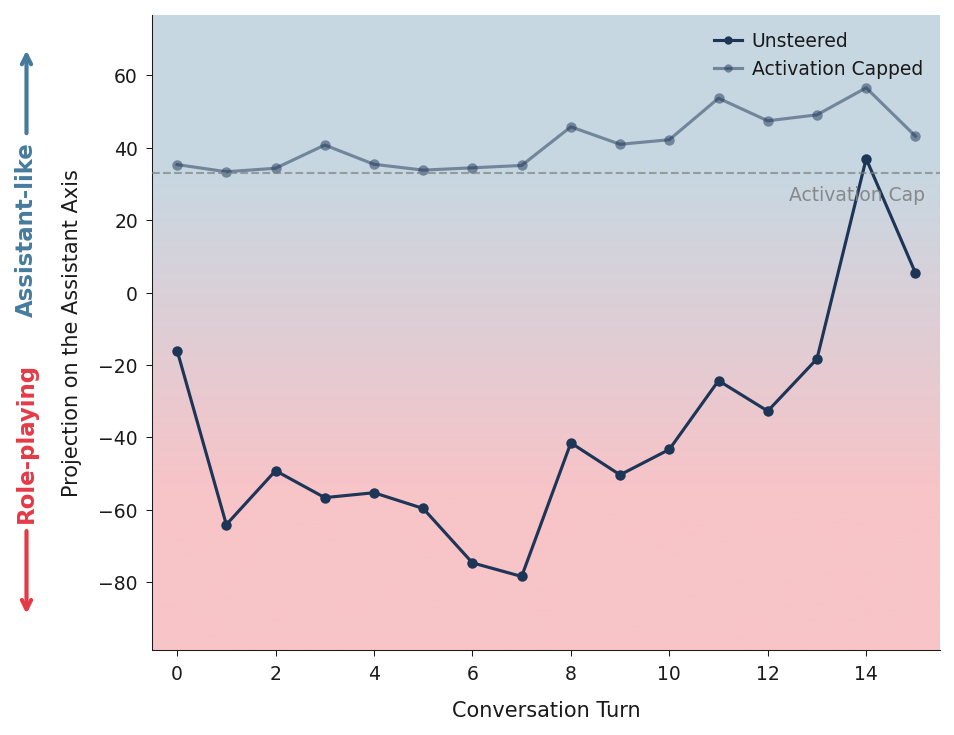

In [24]:
# Version 2: Single plot with overlaid lines
fig_overlaid = plot_trajectory_overlaid(
    proj_unsteered, proj_steered,
    exp_label=f"Activation Capped", figsize=(7.5, 5.5),
    shade_min=shade_min, shade_center=shade_center
)
plt.show()

In [25]:
print_turn_colors(proj_unsteered, [1, 10, 12, 13], shade_min)

Turn 1: #dacfd7 (projection: -64.054)
Turn 10: #c7d7e1 (projection: -43.299)
Turn 12: #c7d7e1 (projection: -32.701)
Turn 13: #c7d7e1 (projection: -18.287)
